In [ ]:
'''todo: confusion matrix
write up
create some other models to compare 
explore clustering
explore other models


'''

In [1]:
'''
I used this site to learn how to convert my two folder of pictures into a train/test data split
(view in incognito)
https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6'''

'''
https://www.kaggle.com/ciplab/real-and-fake-face-detection for the dataset used
'''

'\nhttps://www.kaggle.com/ciplab/real-and-fake-face-detection for the dataset used\n'

In [1]:
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV3Small
from tensorflow.keras import models, layers, optimizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline 

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6



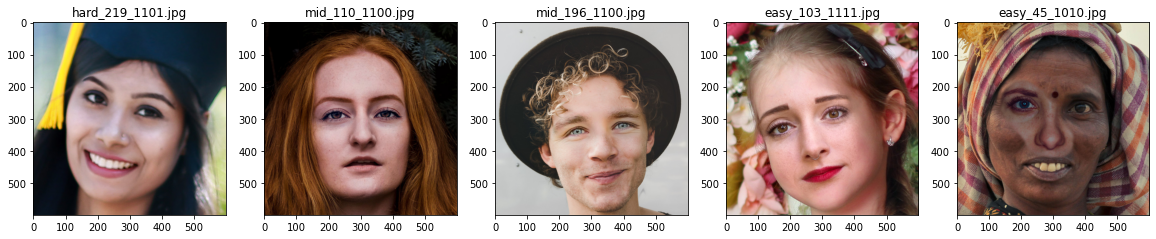

In [3]:
plt.figure(figsize=(20,20))

fake_folder = r'real_and_fake_face\training_fake'
IMG_WIDTH = 224
IMG_HEIGHT = 224

for i in range(5):
    file = random.choice(os.listdir(fake_folder))
    image_path = os.path.join(fake_folder, file)
    img = mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [4]:
'''https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
for explaining the weird indexing'''
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder,dir1)):
            image_path = os.path.join(img_folder, dir1, file)
            image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(IMG_HEIGHT,IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image[:,:,::-1]) #I need to do this weird indexing because otherwise its stored as BGR as per cv2 using BGR instead of RGB
            class_name.append(dir1)
    return img_data_array, class_name



In [5]:
img_data, class_name = create_dataset(r'real_and_fake_face')
img_data = np.array(img_data)
y = np.array(class_name)

In [6]:
print(len(class_name))

2041


In [14]:
#converts the class_name array into 0,1 for false, true respectively
#code taken from https://stackoverflow.com/questions/19766757/replacing-numpy-elements-if-condition-is-met
#0 = training_real
#1 = training_fake

y = (y == 'training_fake').astype(int)

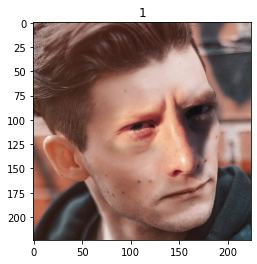

In [9]:
plt.imshow(img_data[111])
plt.title(y[111])
plt.show()

In [15]:
'''uses Sklearn to split data to training(67%) and test(33%)'''
'''https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn'''
X_train, X_val, y_train, y_val = train_test_split(img_data, y, test_size=0.15, random_state = 1)
print(len(X_train))
print(len(X_val))

1734
307


In [11]:
'''https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/'''
'''the extra param is needed to be able to change the input size
Information was taken from the above site'''
new_input = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
VGG_model = VGG16(include_top = False,weights='imagenet', input_tensor = new_input, classes = 2)


In [12]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
#freeze layers
for layer in VGG_model.layers[:15]:
    layers.trainable = False
    
model = Sequential()
model.add(VGG_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation = 'PReLU'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation = 'PReLU'))
#model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 512)               12846080  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0

In [14]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=1e-5),
metrics=['accuracy'])

In [15]:
'''i noticed my val_accuracy still incrementing ever so slightly so I implemented earlystopping and set the epoch to a high count
source: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd'''
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20)
history=model.fit(X_train, y_train,
                  validation_data=(X_val,y_val),
                  batch_size=32,
                  epochs=200,
                  verbose=1,
                  shuffle=True,
                  callbacks=[early_stopping]
)

Epoch 1/200
55/55 [==============================] - 28s 282ms/step - loss: 0.8671 - accuracy: 0.5340 - val_loss: 0.8118 - val_accuracy: 0.4528
Epoch 2/200
55/55 [==============================] - 11s 200ms/step - loss: 0.6460 - accuracy: 0.6378 - val_loss: 0.7577 - val_accuracy: 0.4951
Epoch 3/200
55/55 [==============================] - 11s 199ms/step - loss: 0.5874 - accuracy: 0.6938 - val_loss: 0.7139 - val_accuracy: 0.5342
Epoch 4/200
55/55 [==============================] - 11s 196ms/step - loss: 0.5237 - accuracy: 0.7463 - val_loss: 0.6948 - val_accuracy: 0.5603
Epoch 5/200
55/55 [==============================] - 11s 197ms/step - loss: 0.4690 - accuracy: 0.7809 - val_loss: 0.6712 - val_accuracy: 0.6450
Epoch 6/200
55/55 [==============================] - 11s 202ms/step - loss: 0.3789 - accuracy: 0.8356 - val_loss: 0.6421 - val_accuracy: 0.6580
Epoch 7/200
55/55 [==============================] - 11s 204ms/step - loss: 0.3298 - accuracy: 0.8599 - val_loss: 0.6754 - val_accuracy:

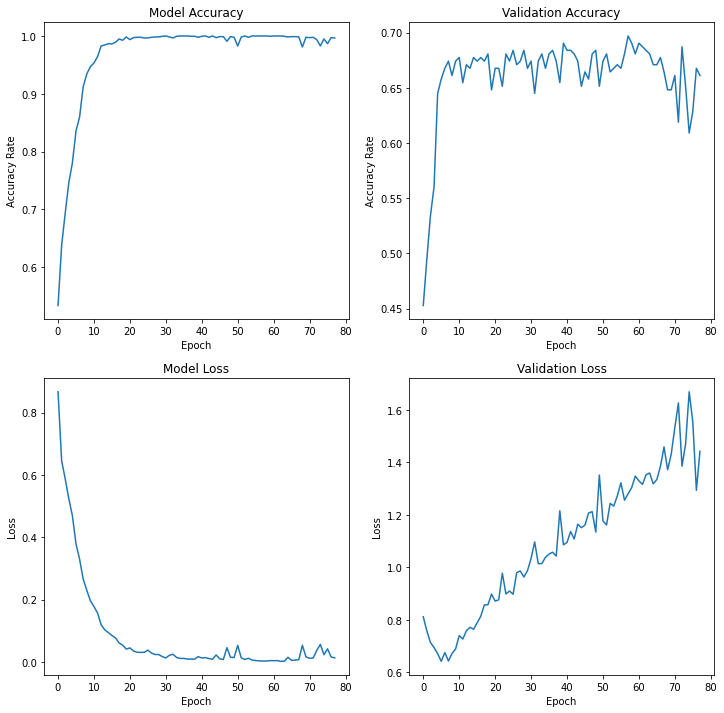

In [19]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(history.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()

In [18]:
model.save('fake faces1', save_format="h5")

In [9]:
'''https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/'''
'''the extra param is needed to be able to change the input size
Information was taken from the above site'''
new_input = tf.keras.Input(shape=(IMG_WIDTH,IMG_HEIGHT,3))
mobilenet_model = MobileNetV3Small(include_top = False,weights='imagenet', input_tensor = new_input, classes = 2)


In [17]:
for layer in mobilenet_model.layers:
    layers.trainable = False

model = Sequential()
model.add(mobilenet_model)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation = 'PReLU'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation = 'PReLU'))
#model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               525312    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)              

In [19]:
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=5e-5),
metrics=['accuracy'])

#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
mobile_history=model.fit(
    X_train,y_train,
    validation_data = (X_val,y_val),
    batch_size = 64,
    epochs = 10,
    verbose=1,
    shuffle=True
)


Epoch 1/10
28/28 [==============================] - 7s 108ms/step - loss: 0.5802 - accuracy: 0.8218 - val_loss: 0.6900 - val_accuracy: 0.5472
Epoch 2/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5547 - accuracy: 0.8610 - val_loss: 0.6938 - val_accuracy: 0.5472
Epoch 3/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5451 - accuracy: 0.8829 - val_loss: 0.6982 - val_accuracy: 0.5472
Epoch 4/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5292 - accuracy: 0.9043 - val_loss: 0.7015 - val_accuracy: 0.5472
Epoch 5/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5214 - accuracy: 0.9216 - val_loss: 0.7035 - val_accuracy: 0.5472
Epoch 6/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5127 - accuracy: 0.9337 - val_loss: 0.7048 - val_accuracy: 0.5472
Epoch 7/10
28/28 [==============================] - 2s 82ms/step - loss: 0.5037 - accuracy: 0.9504 - val_loss: 0.7053 - val_accuracy: 0.5472
Epoch 8/10
2

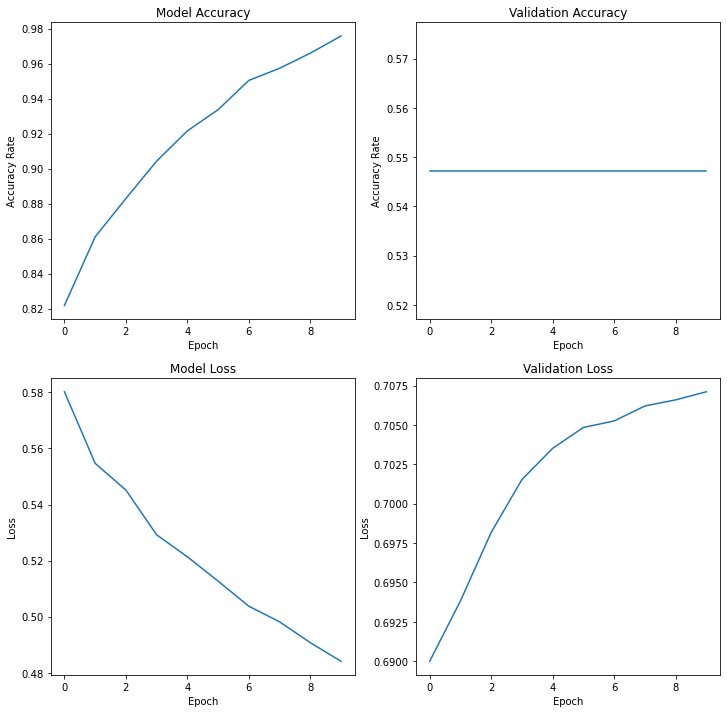

In [20]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
axs[0,0].plot(mobile_history.history['accuracy'])
axs[0,0].set_title('Model Accuracy')
axs[0,0].set(ylabel='Accuracy Rate')
axs[0,0].set(xlabel='Epoch')
axs[0,1].plot(mobile_history.history['val_accuracy'])
axs[0,1].set_title('Validation Accuracy')
axs[0,1].set(ylabel='Accuracy Rate')
axs[0,1].set(xlabel='Epoch')
axs[1,0].plot(mobile_history.history['loss'])
axs[1,0].set_title('Model Loss')
axs[1,0].set(ylabel='Loss')
axs[1,0].set(xlabel='Epoch')
axs[1,1].plot(mobile_history.history['val_loss'])
axs[1,1].set_title('Validation Loss')
axs[1,1].set(ylabel='Loss')
axs[1,1].set(xlabel='Epoch')
plt.show()